In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [ ]:
!pip install -q contractions==0.0.48

In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [ ]:
filename1 = '../input/news-summary/news_summary.csv'
filename2 = '../input/news-summary/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [ ]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
1722,Chhavi Tyagi,"06 Jan 2017,Friday","Modi must go, let Advani, Jaitley or Rajnath l...",http://indiatoday.intoday.in/story/modi-advani...,West Bengal Chief Minister Mamata Banerjee on ...,A belligerent Mamata Banerjee continued her at...
1354,Chhavi Tyagi,"31 Jan 2017,Tuesday",Former Minister E Ahamed collapses in Parliament,http://indiatoday.intoday.in/story/kerala-mp-e...,"E Ahamed, the former MoS for external affairs ...",IUML leader E Ahamed today suffered a heart at...
3951,Tarun Khanna,"04 Apr 2017,Tuesday","Give us EVM for 72 hrs, will show how to rig i...",http://indiatoday.intoday.in/story/election-co...,Delhi CM Arvind Kejriwal has challenged the El...,The Election Commission (EC) has refuted the a...
1961,Vaibhav Gupta,"21 Dec 2016,Wednesday",Note ban has reduced Andhra's revenue by 30%: ...,http://indiatoday.intoday.in/story/note-ban-hi...,Andhra Pradesh Finance Minister Y Ramakrishnud...,"Vijayawada, Dec 21 (PTI) Demonetisation has le..."
465,Radhika Chugh,"27 Jul 2017,Thursday",6 Congress MPs suspended from Lok Sabha,http://www.hindustantimes.com/india-news/six-c...,Lok Sabha Speaker Sumitra Mahajan on Monday su...,The Lok Sabha Speaker suspended six Congress p...


In [ ]:
df2.sample(5)

,headlines,text
53041,Selling sex in Bollywood is dead: Filmmaker Vi...,"Filmmaker Vikram Bhatt, who is known for his b..."
61744,Telangana govt declares Urdu as second officia...,Telangana Chief Minister K Chandrashekar Rao o...
4742,Vanakam Puducherry: Rahul says is PM's answer ...,Taking a dig at PM Narendra Modi for allegedly...
34195,Let's not explore political mileage in Ram's n...,"Talking about the Ayodhya dispute, Vishva Hind..."
26730,"Disappointed, not surprised: Cyrus Mistry on N...",Cyrus Mistry has said he was disappointed but ...


In [ ]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
45406,Former Huawei engineer 'marries' robot he buil...,"A former Huawei engineer from China has ""marri..."
101543,Aus brand creates Harry Potter-inspired clothi...,Australian fashion label Black Milk has create...
24029,Australia to sell Kesar variety of Indian mang...,Australia will be selling Kesar variety of Ind...
15782,White House hires outside counsel to deal with...,US Vice President Mike Pence has reportedly hi...
44624,"AT&T updates 4G logo with '5G E', criticised f...",US-based telco AT&T received criticism from it...


In [ ]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
22697,"92 witnesses, 100 evidences in mandsaur gangra...",mandsaur police on tuesday filed a 350-page ch...
79342,pm modi meets fishermen affected by cyclone ockhi,prime minister narendra modi on tuesday met fi...
51795,can't eat dal-chawal all day: shreyas on doing...,"shreyas talpade has said, ""one can't eat 'dal-..."
33033,govt restricts operations of 2.09 lakh firms' ...,finance ministry on tuesday said operations of...
51218,suffering from facial paralysis: simran writer...,"apurva asrani, co-writer of kangana ranaut's '..."


In [ ]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
69141,"who are the sentinelese, tribe that killed an ...",the sentinelese are an indigenous tribe who ha...
8469,internet should be utility available to whole ...,"chinas e-commerce giant alibabas founder, jack..."
41465,"maoists kill watchman, set ablaze 5 vehicles i...","maoists shot dead a watchman, suspecting him t..."
99162,salmans nephew ahils 1st birthday celebrated i...,salman khans sister arpita khan sharma shared ...
15109,"perhaps rahul plans to win polls in russia, in...","mocking congress vice president rahul gandhi, ..."


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
54141,jpmorgan made bn months record us bank,jpmorgan chase biggest us bank made billion pa...
10135,google like cult says engineer fired mthemo,former google engineer james damore fired page...
12851,ban plying atm cash vans pm mha suggests centre,ministry home affairs mha proposed atms replen...
39281,ongc gives inprinciple nod acquire govts stake...,board staterun oil natural gas corporation ong...
75117,pakistan allocates aaa1 crore defence,pakistan finance minister miftah ismail friday...


In [ ]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [ ]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [ ]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 300)      29932800    input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 42, 240), (N 519360      embedding_2[0][0]                
____________________________________________________________________________________________

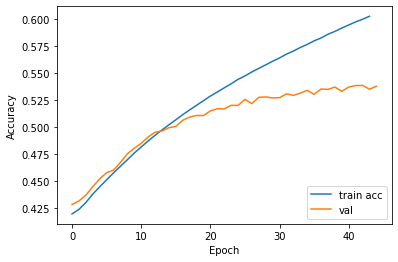

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

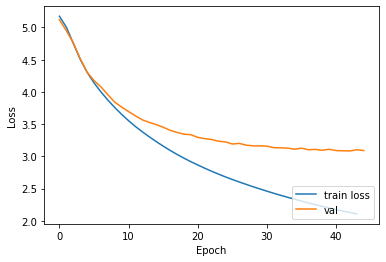

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 42, 300)           29932800  
_________________________________________________________________
lstm_3 (LSTM)                [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_4 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 30,913,920
Trainable params: 981,120
Non-trainable params: 29,932,800
_________________________________________________________________


In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    11257200    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

**Model with Bidirectional LSTMs**

In [ ]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 42, 300)      29932800    input_11[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 42, 480), (N 1038720     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

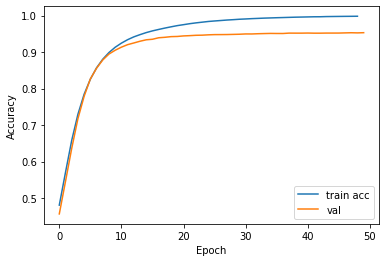

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

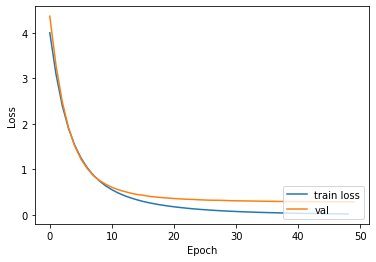

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
encoder_embedding (Embedding (None, 42, 300)           29932800  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 42, 480), (None,  1038720   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 42, 480), (None,  1384320   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 42, 480), (None,  1384320   
Total params: 33,740,160
Trainable params: 3,807,360
Non-trainable params: 29,932,800
_________________________________________________________________


In [ ]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    11257200    input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 240)]        0                                            
____________________________________________________________________________________________

### Model with hybrid architecture

In [ ]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 42, 300)      29932800    input_18[0][0]                   
__________________________________________________________________________________________________
encoder_bidirectional_lstm_1 (B [(None, 42, 480), (N 1038720     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________

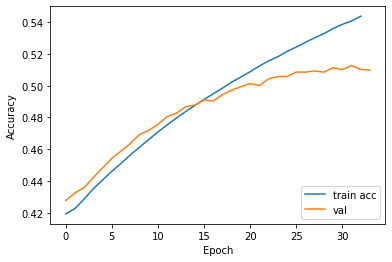

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

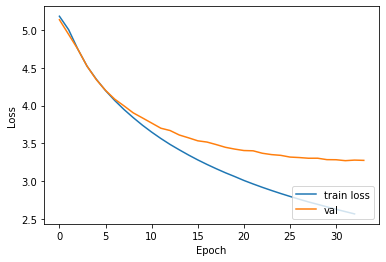

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
encoder_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
encoder_embedding (Embedding (None, 42, 300)           29932800  
_________________________________________________________________
encoder_bidirectional_lstm_1 [(None, 42, 480), (None,  1038720   
_________________________________________________________________
encoder_bidirectional_lstm_2 [(None, 42, 480), (None,  1384320   
_________________________________________________________________
encoder_bidirectional_lstm_3 [(None, 42, 480), (None,  1384320   
Total params: 33,740,160
Trainable params: 3,807,360
Non-trainable params: 29,932,800
_________________________________________________________________


In [ ]:
decoder_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 300)    11257200    input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 240)]        0                                            
____________________________________________________________________________________________

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  spanish fashion retailer zara withdrawn skirt website facing criticism featuring pepe frog internet mtheme turned symbol white nationalist altright movthement zara seriously wallet shopping elsewhere commented user hmm pepe zara skirt wtf read another comment 
Original summary:  start zara withdraws skirt featuring pepe frog altright mtheme end 
Predicted summary:   sostok abvp instagram dthemocracy filed filed filed volcano start india end end

# 2 News:  elections fill vacant seats rajya sabha held today mthembers elected unopposed one seats facing byelections kerala mp resigned mber mthembers uttar pradesh maharashtra bihar six mthembers gujarat four 
Original summary:  start explained details rajya sabha election held today end 
Predicted summary:   sostok fm ied using lawyer lawyer lawyer birth start india end end

# 3 News:  first posthumous nobel prize awarded swedens erik karlfeldt literature posthumous nobel peace prize given youngest united nations secretarygeneral